# Facial Keypoints Detection

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage, misc

# Read the data

In [303]:
train = pd.read_csv("./data/training.csv")
test = pd.read_csv("./data/test.csv")
lookup = pd.read_csv("./data/IdLookupTable.csv")
sample = pd.read_csv("./data/SampleSubmission.csv")

In [304]:
print("Train data length = ", len(train))
print("Test data length = ", len(test))

Train data length =  7049
Test data length =  1783


# Check for nulls and split into good data and bad data

In [305]:
# check for null values
print(f"Feature \t\t\t Missing \t Percentage\n")
for k, v in train.isna().sum().items():
    print(f"{k !s:30} :{v :8} \t {round(v/len(train), 2)}%")

Feature 			 Missing 	 Percentage

left_eye_center_x              :      10 	 0.0%
left_eye_center_y              :      10 	 0.0%
right_eye_center_x             :      13 	 0.0%
right_eye_center_y             :      13 	 0.0%
left_eye_inner_corner_x        :    4778 	 0.68%
left_eye_inner_corner_y        :    4778 	 0.68%
left_eye_outer_corner_x        :    4782 	 0.68%
left_eye_outer_corner_y        :    4782 	 0.68%
right_eye_inner_corner_x       :    4781 	 0.68%
right_eye_inner_corner_y       :    4781 	 0.68%
right_eye_outer_corner_x       :    4781 	 0.68%
right_eye_outer_corner_y       :    4781 	 0.68%
left_eyebrow_inner_end_x       :    4779 	 0.68%
left_eyebrow_inner_end_y       :    4779 	 0.68%
left_eyebrow_outer_end_x       :    4824 	 0.68%
left_eyebrow_outer_end_y       :    4824 	 0.68%
right_eyebrow_inner_end_x      :    4779 	 0.68%
right_eyebrow_inner_end_y      :    4779 	 0.68%
right_eyebrow_outer_end_x      :    4813 	 0.68%
right_eyebrow_outer_end_y      :    481

In [306]:
# split into good data and bad data
good_train = train.dropna()
bad_train = train.drop(index=good_train.index)

# Work on the Good Data

In [307]:
good_train.shape

(2140, 31)

In [308]:
good_train["Image"].head()

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

# Function that extracts the images and targets from a CSV file

In [309]:
def get_images(data):
    images = []

    # prepare the image
    for img in iter(data.loc[:, "Image"]):
        img = np.array(img.split(), dtype=float)
        img = img.reshape(96, 96, 1)
        images.append(img)
    return np.array(images)

def get_xy(data):
    images = get_images(data)
    targets = np.array(data.iloc[:, :-1], dtype=float)
    return images, targets

In [310]:
images, targets = get_xy(good_train)

In [311]:
print("Shape of images = ", images.shape)
print("Shape of targets = ", targets.shape)

Shape of images =  (2140, 96, 96, 1)
Shape of targets =  (2140, 30)


# Display the images

In [350]:
def show_images(img, feat):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(feat[0::2], feat[1::2], c="r", marker="x")

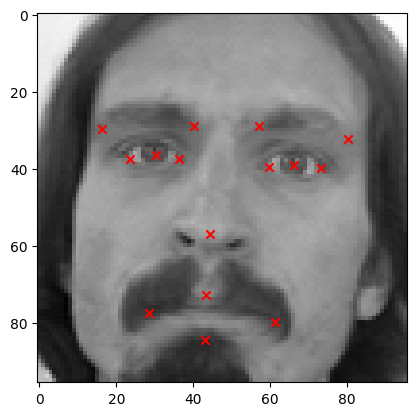

In [359]:
show_images(images[0], targets[0])
bob_image, bob_feats = images[1], targets[1]

## Augmentation
We can build a larger train set by augmenting the already existing data. This process will account for variations in the pictures of a given individual, such as different viewing angles, lighting, camera quality etc.

Types of augmentation:
* Flippiing
* Rotation
* Cropping
* Adding Noise
* Blurring
* Brightness

In [352]:
# display the augmentation
def show_augmentation(img, feat, img_f, feat_f):
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(feat[0::2], -feat[1::2], c="r", marker="x")

    plt.subplot(2, 2, 2)
    plt.scatter(feat_f[0::2], -feat_f[1::2], c="r", marker="x")

    plt.subplot(2, 2, 3)
    show_images(img, feat)

    plt.subplot(2, 2, 4)
    show_images(img_f, feat_f)

## Flip

In [353]:
def aug_flip(images, features):
    flipped_images = np.flip(images, axis=2)

    flipped_features = features.copy()
    for i, feat in enumerate(flipped_features):
        for j, val in enumerate(feat):
            if j % 2 == 0:
                flipped_features[i][j] = 96 - val
    return flipped_images, flipped_features

augmentation_functions = {
    "flip": aug_flip
}

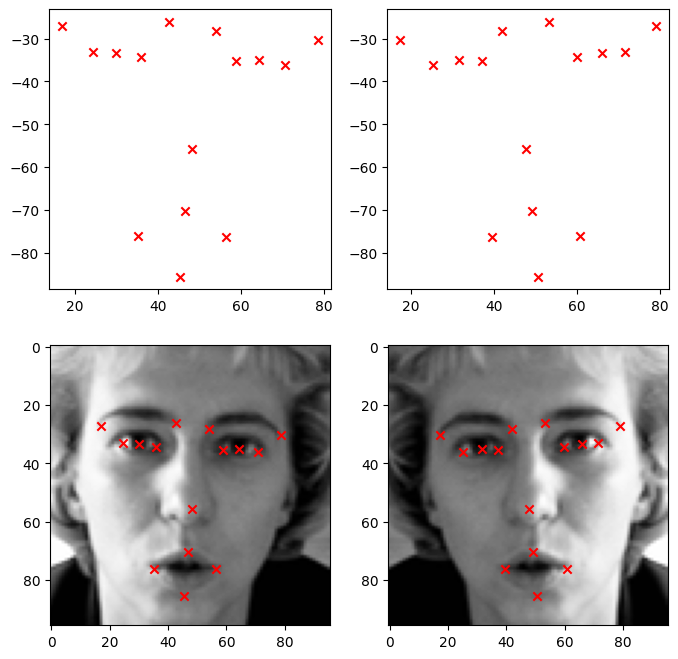

In [354]:
flip_imgs, flipped_feats = aug_flip(images[:5], targets[:5])
i = 1
show_augmentation(images[i], targets[i], flip_imgs[i], flipped_feats[i])

## Crop

In [334]:
def aug_crop(images, features):
    cropped_images = images.copy()

    for i in range(len(images)):
        cropped_images[i, :, :10] = 0
        cropped_images[i, :, 86:] = 0
        cropped_images[i, :10, :] = 0
        cropped_images[i, 86:, :] = 0
    return cropped_images, features

augmentation_functions["crop"] = aug_crop

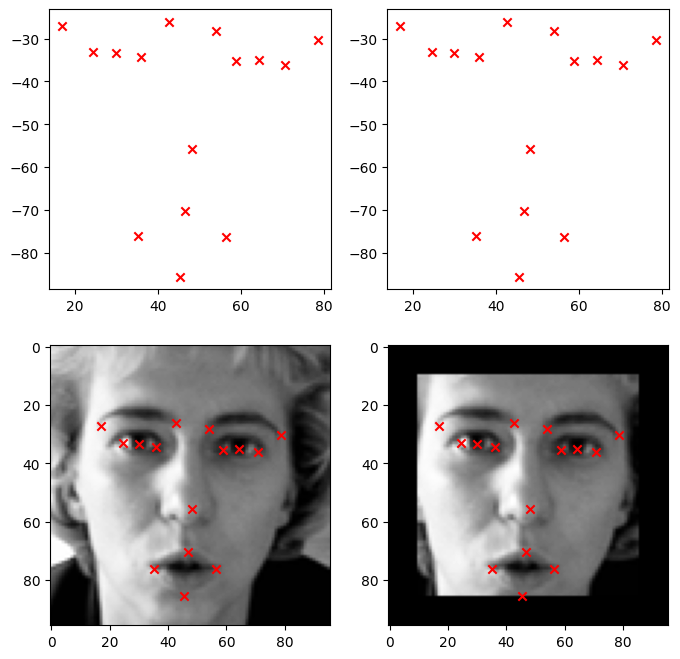

In [356]:
cropped_images, features = aug_crop(images[:5], targets[:5])
show_augmentation(images[1], features[1], cropped_images[1], features[1])

## Rotation

In [328]:
def rotate_points(points, angle):
    # shift points so that the center of rotation is at the origin
    points_copy = points.copy()
    points_copy -= 48

    # rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))

    # rotate the points
    for i in range(0, len(points), 2):
        xy = np.array([points_copy[i], points_copy[i+1]])
        xy_rot = R @ xy
        points_copy[i], points_copy[i+1] = xy_rot

    # shift the points back to their original spot
    points_copy += 48
    
    return points_copy

In [333]:
# lets make an util that give us rotated images and targets
def aug_rotate(images, features, angle):
    rotated_images = []
    for img in images:
        img_rot = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(img_rot)
        
    rotated_features=[]
    for feat in features:
        feat_rot = rotate_points(feat, angle)
        rotated_features.append(feat_rot)
        
    
    return np.array(rotated_images), np.array(rotated_features)

augmentation_functions['rotate'] = aug_rotate

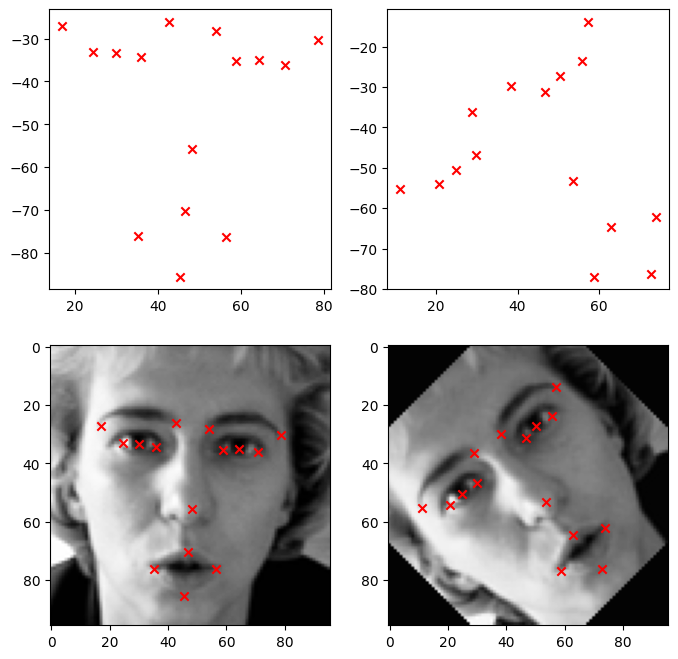

In [332]:
img_rot, feat_rot = aug_rotate(images[:5], targets[:5], angle=45)
show_augmentation(images[1], targets[1], img_rot[1], feat_rot[1])

## Brightness

In [327]:
def aug_bright(images, features, factor=1.5):
    bright = []
    for img in images:
        bright.append(np.clip(img * factor, 0, 255))
    return np.array(bright), features

augmentation_functions["brightness"] = aug_bright

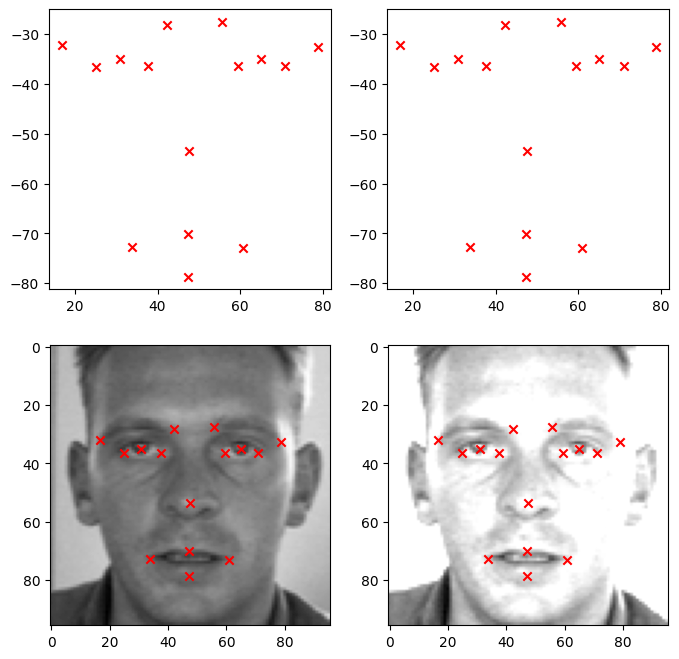

In [323]:
bright, features = aug_bright(images[:5], targets[:5], factor=2)
show_augmentation(images[2], targets[2], bright[2], features[2])

## Noise

In [326]:
def aug_noise(images, features, factor):
    augmented = []
    noise = np.random.randint(low=0, high=255, size=images.shape[1:])
    for img_og in images:
        img = img_og.copy()
        img += noise * factor
        augmented.append(img)
    return np.array(augmented), features

augmentation_functions["noise"] = aug_noise

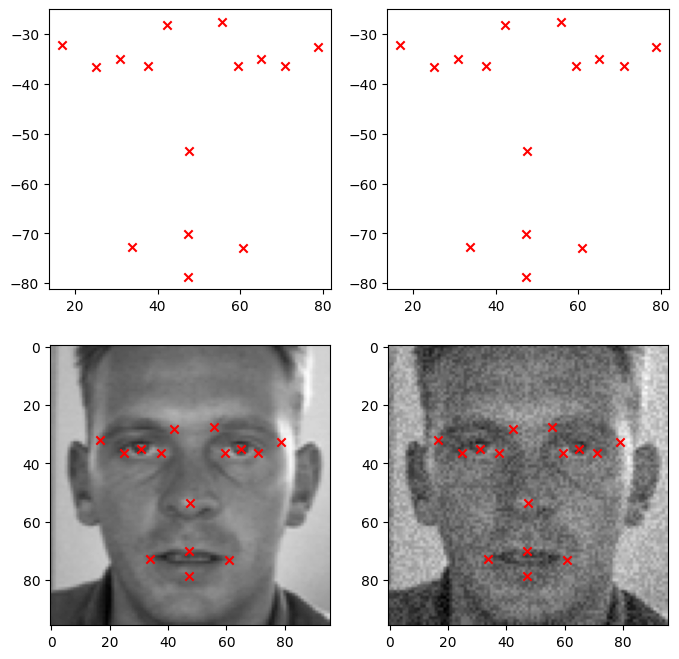

In [325]:
img, ft = aug_noise(images[:5], targets[:5], factor=0.2)
show_augmentation(images[2], targets[2], img[2], ft[2])

## Add Augmentation

In [335]:
def add_augmentation(img, feat, method):
    aug_img, aug_feat = method
    img = np.concatenate([img, aug_img])
    feat = np.concatenate([feat, aug_feat])
    return img, feat

In [367]:
# flip
method = aug_flip(images, targets)
augmented_images, augmented_targets = add_augmentation(images, targets, method)
print("Augmentation added: Flipping")

# crop
method = aug_crop(images, targets)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Cropping")

# rotate
for theta in [10, 12, 15, -10, -12, -15]:
    method = aug_rotate(images, targets, angle=theta)
    augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
    print("Augmentation added: Rotation: ", theta)

# brightness
method = aug_bright(images, targets)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Brightness")

# noise
method = aug_noise(images, targets, factor=0.2)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Noise")

Augmentation added: Flipping
Augmentation added: Cropping
Augmentation added: Rotation:  10
Augmentation added: Rotation:  12
Augmentation added: Rotation:  15
Augmentation added: Rotation:  -10
Augmentation added: Rotation:  -12
Augmentation added: Rotation:  -15
Augmentation added: Brightness
Augmentation added: Noise


## Shape of new data

In [368]:
print("Shape of data after augmentation:")
print("Shape of image data  - ", augmented_images.shape)
print("Shape of target data - ", augmented_targets.shape)

Shape of data after augmentation:
Shape of image data  -  (23540, 96, 96, 1)
Shape of target data -  (23540, 30)


## Visualize the new data

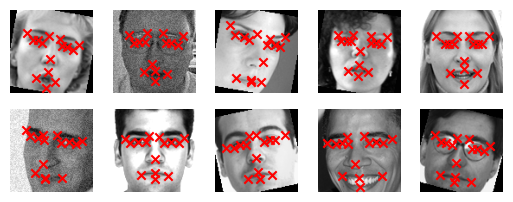

23540


In [371]:
def visualize_data(images, targets):
    for i in range(10):
        idx = np.random.randint(images.shape[0])
        plt.subplot(2, 5, i + 1)
        show_images(augmented_images[idx], augmented_targets[idx])
        plt.axis("off")
    plt.subplots_adjust(bottom=0.5)
    plt.show()

visualize_data(augmented_images, augmented_targets)
print(augmented_images.shape[0])

# Model